In [1]:
import scipy.io as sio
import torch
import glob
import numpy
import torch.nn.functional as F
def get_freq(indices):
    freq = torch.zeros(8192)
    indices = indices.flatten()
    for indice in indices:
        freq[indice] += 1
    return freq

# # 统计所有indice出现的频次，直方图
root_path = '../work_dirs/anal/val'
list = glob.glob(root_path + '/*')

data = sio.loadmat(list[3])
print(data.keys())
print('semantic_seg_pred', data['semantic_seg_pred'].shape)
print('gt_semantic_seg', data['gt_semantic_seg'].shape)
print('vq_indices', data['vq_indices'].shape)
print('vq_indice_gt', data['vq_indice_gt'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'semantic_seg_pred', 'gt_semantic_seg', 'vq_indices', 'vq_indice_gt'])
semantic_seg_pred (1, 1, 1024, 2048)
gt_semantic_seg (1, 1, 1024, 2048)
vq_indices (1, 1, 128, 256)
vq_indice_gt (1, 1, 128, 256)


In [2]:
from IPython.display import display, Image

freq = get_freq(data['vq_indice_gt'])
print('sum', freq.sum().item())
freq[freq != 0] = 1
print('zeros', freq.sum().item())
print()


sum 32768.0
zeros 2562.0



In [3]:
def draw_segmap_from_indice(indice):
    return encode_to_segmap(F.interpolate(torch.tensor(indice).float(), size=data['vq_indices'].shape[-2:], mode='nearest'))[0].permute(1, 2, 0)

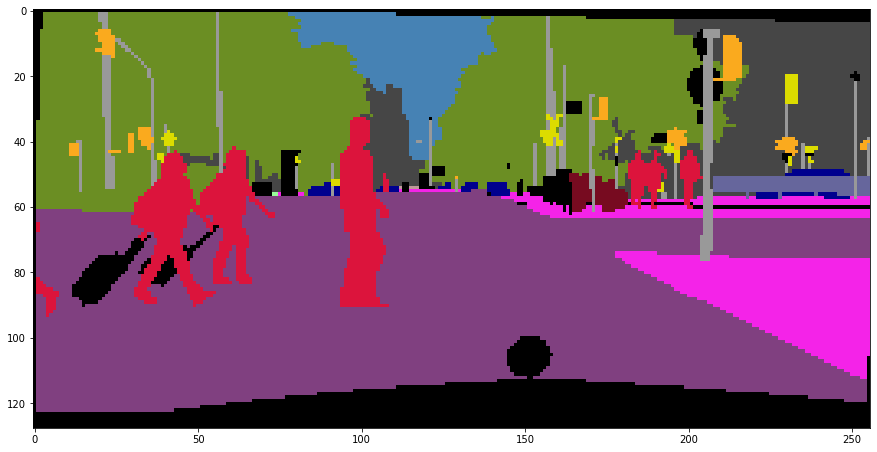

In [4]:
import matplotlib.pyplot as plt
import torch
from mmseg.models.utils.dalle_d_vae import get_dalle_vae, map_pixels, unmap_pixels, encode_to_segmap, decode_from_segmap
plt.figure(figsize=(15,10))
gt_seg_map = draw_segmap_from_indice(data['gt_semantic_seg'])
pred_seg_map = draw_segmap_from_indice(data['semantic_seg_pred'])
plt.imshow(gt_seg_map)

plt.show()

In [20]:
CLASSES = ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
           'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
           'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
           'bicycle')

PALETTE = [[128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
           [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
           [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
           [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
           [0, 80, 100], [0, 0, 230], [119, 11, 32]]

gt_semantic_seg = torch.tensor(data['gt_semantic_seg'])
pred_pixel = torch.tensor(data['semantic_seg_pred'])
gt_vq_indices = torch.tensor(data['vq_indice_gt'])


筛选出所有实体，这些实体都是需要尽可能地保护的，尽量不要被ignore的区域影响到

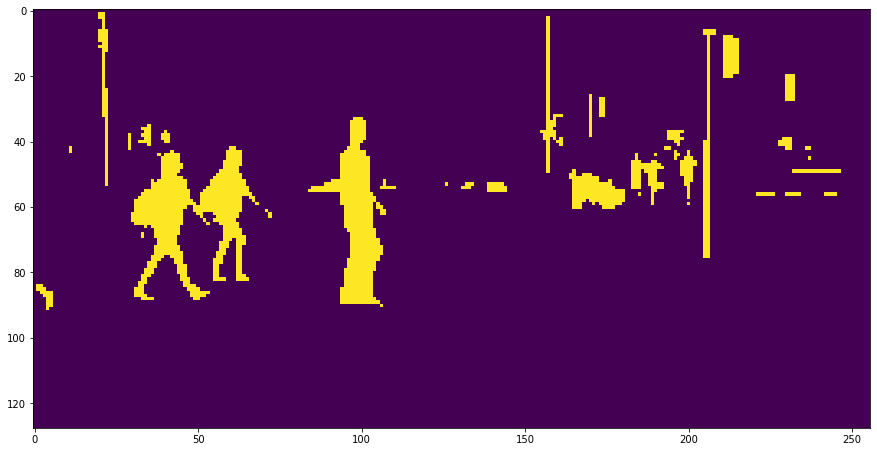

In [53]:
things = [4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18]

gt = torch.tensor(data['gt_semantic_seg'])
things_map = torch.zeros_like(gt).float()
gt[gt > 19] = 19
gt_logist = F.one_hot(gt.to(torch.int64), 20).squeeze(1).permute(0, 3, 1, 2).to(torch.float)
for thing in things:
    things_map += gt_logist[:, thing:thing+1,:,:]
things_map = 1 - things_map
things_map = F.avg_pool2d(things_map.float(), kernel_size=(8, 8), stride=(4, 4))
things_map = F.interpolate(things_map.float(), size=gt_vq_indices.shape[-2:], mode='bilinear')
things_map[things_map < 0.05] = 0
things_map[things_map > 0 ] = 1
things_map = 1 - things_map
plt.figure(figsize=(15,10))
plt.imshow(things_map[0,0])
plt.show()

ignore区域的indice

/tmp/ipykernel_19393/887121892.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignore_area_mask = torch.zeros_like(torch.tensor(gt_semantic_seg))
/tmp/ipykernel_19393/887121892.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignore_area = torch.tensor(gt_semantic_seg >= 19)


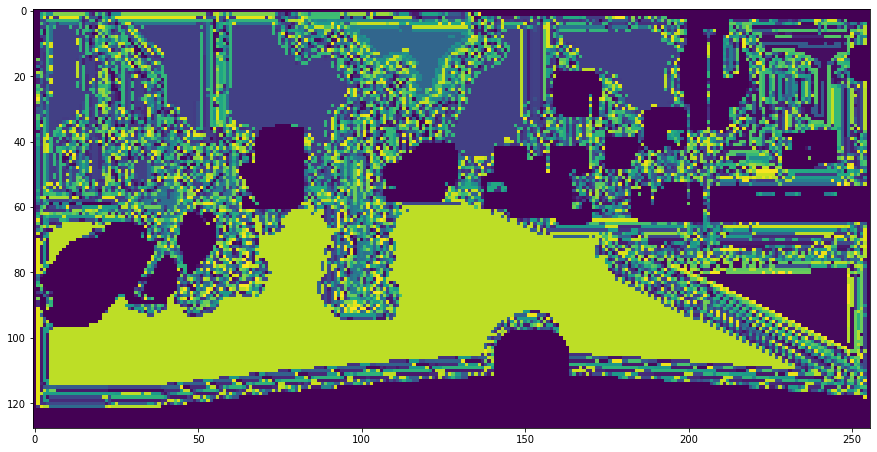

In [56]:
h, w = gt_vq_indices.shape[-2:]
ignore_area_mask = torch.zeros_like(torch.tensor(gt_semantic_seg))

ignore_area = torch.tensor(gt_semantic_seg >= 19)
ignore_area_mask[ignore_area] = 1

ignore_area_mask = F.avg_pool2d(ignore_area_mask.float(), kernel_size=(81, 81), stride=(1, 1))

ignore_area_mask = F.interpolate(ignore_area_mask, size=(h, w), mode='bilinear')
ignore_area_mask[ignore_area_mask > 0.02] = 1
# ignore_area_mask = F.interpolate(ignore_area_mask.float(), size=gt_vq_indices.shape[-2:], mode='nearest')

ignore_area_mask = 1 - ignore_area_mask # 被ignore区域为0，没有被ignore区域为1
mask = ignore_area_mask + things_map
mask[mask > 0] = 1
mask_gt_vq_indices = mask * gt_vq_indices


plt.figure(figsize=(15,10))
plt.imshow(mask_gt_vq_indices[0,0])
plt.show()